<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PyTorch-Optimizers" data-toc-modified-id="PyTorch-Optimizers-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PyTorch Optimizers</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions-For-Plotting/Animating" data-toc-modified-id="Helper-Functions-For-Plotting/Animating-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper Functions For Plotting/Animating</a></span></li><li><span><a href="#Rosenbrock-Function" data-toc-modified-id="Rosenbrock-Function-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Rosenbrock Function</a></span></li><li><span><a href="#PyTorch-Optimization-Algorithms" data-toc-modified-id="PyTorch-Optimization-Algorithms-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>PyTorch Optimization Algorithms</a></span><ul class="toc-item"><li><span><a href="#torch.optim.Adadelta" data-toc-modified-id="torch.optim.Adadelta-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>torch.optim.Adadelta</a></span></li><li><span><a href="#torch.optim.Adagrad" data-toc-modified-id="torch.optim.Adagrad-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>torch.optim.Adagrad</a></span></li><li><span><a href="#torch.optim.Adam" data-toc-modified-id="torch.optim.Adam-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>torch.optim.Adam</a></span></li><li><span><a href="#torch.optim.AdamW" data-toc-modified-id="torch.optim.AdamW-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>torch.optim.AdamW</a></span></li><li><span><a href="#torch.optim.Adamax" data-toc-modified-id="torch.optim.Adamax-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>torch.optim.Adamax</a></span></li><li><span><a href="#torch.optim.ASGD" data-toc-modified-id="torch.optim.ASGD-1.3.6"><span class="toc-item-num">1.3.6&nbsp;&nbsp;</span>torch.optim.ASGD</a></span></li><li><span><a href="#torch.optim.LBFGS" data-toc-modified-id="torch.optim.LBFGS-1.3.7"><span class="toc-item-num">1.3.7&nbsp;&nbsp;</span>torch.optim.LBFGS</a></span></li><li><span><a href="#torch.optim.RMSprop" data-toc-modified-id="torch.optim.RMSprop-1.3.8"><span class="toc-item-num">1.3.8&nbsp;&nbsp;</span>torch.optim.RMSprop</a></span></li><li><span><a href="#torch.optim.Rprop" data-toc-modified-id="torch.optim.Rprop-1.3.9"><span class="toc-item-num">1.3.9&nbsp;&nbsp;</span>torch.optim.Rprop</a></span></li><li><span><a href="#torch.optim.SGD" data-toc-modified-id="torch.optim.SGD-1.3.10"><span class="toc-item-num">1.3.10&nbsp;&nbsp;</span>torch.optim.SGD</a></span></li></ul></li><li><span><a href="#Newton's-Method-(Using-torch.autograd.functional)" data-toc-modified-id="Newton's-Method-(Using-torch.autograd.functional)-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Newton's Method (Using torch.autograd.functional)</a></span></li></ul></li></ul></div>

# PyTorch Optimizers

In [22]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
print("PyTorch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)

%matplotlib nbagg
plt.interactive(False)

PyTorch version: 1.8.1
Numpy version: 1.19.2
Matplotlib version: 3.3.4


## Helper Functions For Plotting/Animating

In [23]:
def plot_f(f, ax=None, optimum_point=None):
    if ax is None:
        ax = plt.gca()
    x1, x2 = np.mgrid[-3:3:.005, -3:7:.005]
    X = np.dstack((x1, x2))
    Z = f(X)
    ax.contour(x1, x2, Z, levels=64)
    if optimum_point is not None:
        ax.plot(optimum_point[0], optimum_point[1], "*y")


def plot_history(history, linestyle="-k", pointstyle=".r"):
    history = np.array(history)
    p1 = plt.plot(history[:, 0], history[:, 1], linestyle)
    p2 = plt.plot(history[:, 0], history[:, 1], pointstyle)
    return p1, p2


def animate_optimization(f, history, linestyle="-k", pointstyle=".r", title=None, optimum_point=None):
    history_np = np.array(history)
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4)
    xdata, ydata = [], []
    p1, = plt.plot([], [], linestyle, alpha=0.5)
    p2, = plt.plot([], [], pointstyle)

    if title is not None:
        ax.set_title(title)

    def init():
        return p1, p2,

    def update(frame):
        history_np_until_frame = history_np[:frame+1, :]
        p1.set_data(history_np_until_frame[:, 0], history_np_until_frame[:, 1])
        p2.set_data(history_np_until_frame[:, 0], history_np_until_frame[:, 1])
        return p1, p2,

    plot_f(f, optimum_point=optimum_point)
    ani = FuncAnimation(fig, update, frames=len(history_np),
                        init_func=init, blit=True)

    plt.close()

    # return ani.to_jshtml()
    return ani.to_html5_video()


_ = plt.close()


def train(x, f, optimizer, epoch=100, use_closure_func=False):
    # Some optimizers LBFGS needs closure in step function

    if use_closure_func:
        def closure():
            if torch.is_grad_enabled():
                optimizer.zero_grad()
            loss = f(x)
            if loss.requires_grad:
                loss.backward()
            return loss
    else:
        closure = None

    history = [x.detach().numpy().copy()]
    for i in range(epoch):
        optimizer.zero_grad()
        f_out = f(x)
        f_out.backward()
        optimizer.step(closure)
        history.append(x.detach().numpy().copy())
    return history

## Rosenbrock Function

$$
f(x_1, x_2) = b(x_2-x_1^2)^2 + (x_1 - a)^2
$$

Where usually $a=1$ and $b=100$. Optimum point located at $[a,a^2]$

We need two version of the same loss function, one for plotting purposes and another one for PyTorch library.

Optimum point: [1. 1.]
Value at optimum point 0.0


<IPython.core.display.Javascript object>


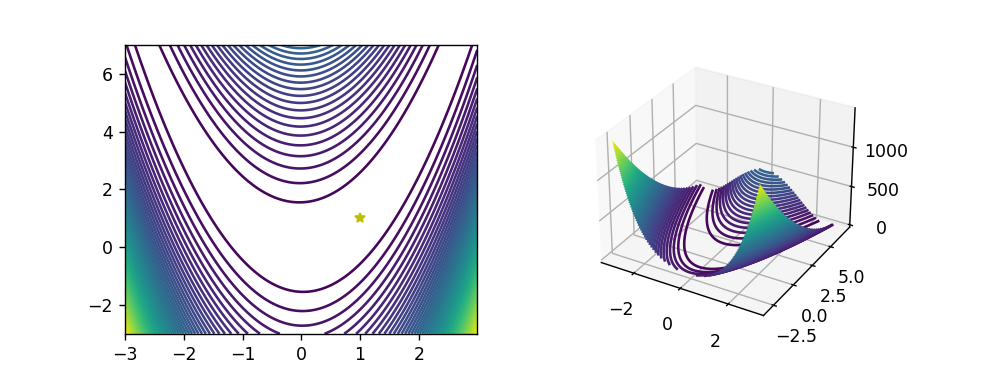

In [24]:
rosenbrock_a = 1.0
rosenbrock_b = 10.0
rosenbrock_optimum = np.array([rosenbrock_a, rosenbrock_a**2])


def rosenbrock(x):
    x1 = x[..., 0]
    x2 = x[..., 1]
    return rosenbrock_b*(x2-x1**2)**2 + (x1-rosenbrock_a)**2


print("Optimum point:", rosenbrock_optimum)
print("Value at optimum point", rosenbrock(rosenbrock_optimum))

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plot_f(rosenbrock, ax1, rosenbrock_optimum)
plot_f(rosenbrock, ax2, rosenbrock_optimum)
fig.show()

## PyTorch Optimization Algorithms

In [25]:
start_point = [-0.5, 6.]

### torch.optim.Adadelta

In [26]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.Adadelta([x], lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.Adadelta",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([-1.0010,  5.6216], requires_grad=True)


### torch.optim.Adagrad

In [27]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.Adagrad([x], lr=1.0, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.Adagrad",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([-1.8784,  3.5964], requires_grad=True)


### torch.optim.Adam

In [28]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.Adam([x], lr=1.0, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.Adam",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([0.8834, 0.7934], requires_grad=True)


### torch.optim.AdamW

In [29]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.AdamW([x], lr=1.0, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.AdamW",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([0.7540, 0.5659], requires_grad=True)


### torch.optim.Adamax

In [30]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.Adamax([x], lr=1.0, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.Adamax",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([-1.1421,  1.3757], requires_grad=True)


### torch.optim.ASGD

In [31]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.ASGD([x], lr=0.008, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.ASGD",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([-0.8523,  0.8071], requires_grad=True)


### torch.optim.LBFGS

In [32]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.LBFGS([x], lr=1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

history = train(x, rosenbrock, optimizer, use_closure_func=True)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.LBFGS",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([1.0000, 1.0000], requires_grad=True)


### torch.optim.RMSprop

In [33]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.RMSprop([x], lr=0.05, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.RMSprop",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([0.6077, 0.3696], requires_grad=True)


### torch.optim.Rprop

In [34]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.Rprop([x], lr=0.1, etas=(0.66, 1.3), step_sizes=(1e-02, 50))

history = train(x, rosenbrock, optimizer, epoch=150)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.Rprop",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([0.9613, 0.9299], requires_grad=True)


### torch.optim.SGD

In [35]:
x = torch.tensor(start_point, requires_grad=True)
optimizer = torch.optim.SGD([x], lr=0.003, momentum=0.9, dampening=0, weight_decay=0, nesterov=True)

history = train(x, rosenbrock, optimizer)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="torch.optim.SGD",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([0.8214, 0.6669], requires_grad=True)


## Newton's Method (Using torch.autograd.functional)

In [36]:
def newtons_method(x, loss_function, epoch, step_size):

    history = [x.detach().numpy().copy()]
    for i in range(epoch):
        H = torch.autograd.functional.hessian(
            loss_function, x).detach().numpy()  # Calculate hessian
        J = torch.autograd.functional.jacobian(
            loss_function, x).detach().numpy()  # Calculate jacobian

        with torch.no_grad():
            x.copy_(x - step_size * (np.linalg.inv(H) @ J))  # update x value

        history.append(x.detach().numpy().copy())
    return x, history


x0 = torch.tensor([-1., -1.], requires_grad=True)
step_size = 0.5
epoch = 30

x, history = newtons_method(x0, rosenbrock, epoch, step_size)
print("Final x:", x)

HTML(animate_optimization(rosenbrock,
                          history,
                          title="Newton's Method",
                          optimum_point=rosenbrock_optimum))

Final x: tensor([1.0000, 1.0000], requires_grad=True)
